# Import packages and modules

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pymc3
import patsy

# set seaborn style
sns.set(palette = "colorblind", font_scale = 2)

# Generate example dataset

In [34]:
# id
subject_id = list(range(120))

# group
group = np.repeat([1, 2, 3, 4], [30, 30, 30, 30])

# factors
factor1 = [{1: "A", 2: "A", 3: "B", 4: "B"}[x] for x in group]
factor2 = [{1: "A", 2: "B", 3: "A", 4: "B"}[x] for x in group]

# y
y = np.concatenate([np.random.normal(m, s, n) for m, s, n in zip([3, 4, 4, 3], [1, 1, 1, 1], [30, 30, 30, 30])])

# store in data frame
tutorial_data = pd.DataFrame({"subject_id": subject_id, "group": group, "factor1": factor1, "factor2": factor2, "y": y})

# see it
tutorial_data

,subject_id,group,factor1,factor2,y
0,0,1,A,A,3.893032
1,1,1,A,A,1.924715
2,2,1,A,A,1.614062
3,3,1,A,A,1.857683
4,4,1,A,A,3.325661
...,...,...,...,...,...
115,115,4,B,B,2.902215
116,116,4,B,B,3.815447
117,117,4,B,B,4.064243
118,118,4,B,B,3.192092


# Plot data, set expectations

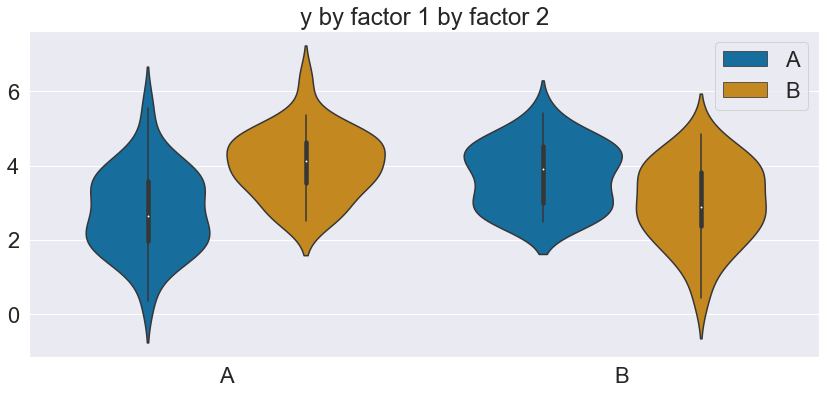

In [35]:
# figure
plt.figure(figsize = (12, 6))

# violin plot
sns.violinplot(x = "factor1", y = "y", hue = "factor2", data = tutorial_data)

# titles
plt.title("y by factor 1 by factor 2")
plt.xlabel(None)
plt.ylabel(None)

# legend
plt.legend(loc = "best")

# fix plot
plt.tight_layout()

# Models

## eta-squared function
$\eta^2 = \frac{SS_{Effect}}{SS_{Total}}$

In [36]:
def eta_squared(anova_lm_df):
    # total sum of squares
    sst = anova_lm_df["sum_sq"].sum()
    
    # add eta_squared to df
    anova_lm_df["eta_squared"] = [ss / sst for ss in anova_lm_df["sum_sq"]]
    
    # return df
    return anova_lm_df

## Treatment/Dummy codes

### Fit model

In [37]:
# index = 0 used as reference group
ols_fit1 = smf.ols("y ~ C(group, Treatment(reference = 0))", data = tutorial_data).fit()

## Coefficient estimates + other model info

In [38]:
ols_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     10.86
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           2.44e-06
Time:                        11:18:56   Log-Likelihood:                -167.19
No. Observations:                 120   AIC:                             342.4
Df Residuals:                     116   BIC:                             353.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 2.7787      0.181     15.354      0.000       2.420       3.137
C(group, Treatment(reference=0))[T.2]     1.2636      0.256      4.937      0.000       0.757       1.771
C(group, Treatment(reference=0))[T.3]     0.9497      0.256      3.710      0.000       0.443       1.457
C(group, Treatment(reference=0))[T.4]     0.2202      0.256      0.860      0.391      -0.287       0.727
==============================================================================
Omnibus:                        0.128   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.301
Skew:                           0.006   Prob(JB):                        0.860
Kurtosis:                       2.755   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA source table

In [39]:
eta_squared(
    sm.stats.anova_lm(ols_fit1, type = 3)
)

,df,sum_sq,mean_sq,F,PR(>F),eta_squared
"C(group, Treatment(reference=0))",3.0,32.000675,10.666892,10.855187,0.000002,0.2192
Residual,116.0,113.987855,0.982654,NaN,NaN,0.7808


## Custom codes

In [40]:
np.array([[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])

array([[-0.5, -0.5,  0.5],
       [-0.5,  0.5, -0.5],
       [ 0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5]])

### Fit model

In [41]:
# index = 0 used as reference group
ols_fit2 = smf.ols("y ~ C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])", data = tutorial_data).fit()

## Coefficient estimates + other model info

In [42]:
ols_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     10.86
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           2.44e-06
Time:                        11:18:57   Log-Likelihood:                -167.19
No. Observations:                 120   AIC:                             342.4
Df Residuals:                     116   BIC:                             353.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================
                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                         3.3871      0.090     37.430      0.000       3.208       3.566
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom0]    -0.0469      0.181     -0.259      0.796      -0.405       0.312
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom1]     0.2671      0.181      1.476      0.143      -0.091       0.626
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom2]    -0.9966      0.181     -5.506      0.000      -1.355      -0.638
==============================================================================
Omnibus:                        0.128   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.301
Skew:                           0.006   Prob(JB):                        0.860
Kurtosis:                       2.755   Cond. No.                         2.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA source table

In [43]:
eta_squared(
    sm.stats.anova_lm(ols_fit2, type = 3)
)

,df,sum_sq,mean_sq,F,PR(>F),eta_squared
"C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])",3.0,32.000675,10.666892,10.855187,0.000002,0.2192
Residual,116.0,113.987855,0.982654,NaN,NaN,0.7808


## Custom codes using factor1 and factor2 variables

In [44]:
np.array([[-0.5], [0.5]])

array([[-0.5],
       [ 0.5]])

### Fit model

In [45]:
# index = 0 used as reference group
ols_fit3 = smf.ols("y ~ C(factor1, [[-0.5], [0.5]]) * C(factor2, [[-0.5], [0.5]])", data = tutorial_data).fit()

## Coefficient estimates + other model info

In [46]:
ols_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     10.86
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           2.44e-06
Time:                        11:18:57   Log-Likelihood:                -167.19
No. Observations:                 120   AIC:                             342.4
Df Residuals:                     116   BIC:                             353.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     3.3871      0.090     37.430      0.000       3.208       3.566
C(factor1, [[-0.5], [0.5]])[custom0]                                         -0.0469      0.181     -0.259      0.796      -0.405       0.312
C(factor2, [[-0.5], [0.5]])[custom0]                                          0.2671      0.181      1.476      0.143      -0.091       0.626
C(factor1, [[-0.5], [0.5]])[custom0]:C(factor2, [[-0.5], [0.5]])[custom0]    -1.9932      0.362     -5.506      0.000      -2.710      -1.276
==============================================================================
Omnibus:                        0.128   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.301
Skew:                           0.006   Prob(JB):                        0.860
Kurtosis:                       2.755   Cond. No.                         4.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA source table

In [47]:
eta_squared(
    sm.stats.anova_lm(ols_fit3, type = 3)
)

,df,sum_sq,mean_sq,F,PR(>F),eta_squared
"C(factor1, [[-0.5], [0.5]])",1.0,0.066015,0.066015,0.067180,7.959465e-01,0.000452
"C(factor2, [[-0.5], [0.5]])",1.0,2.139684,2.139684,2.177454,1.427552e-01,0.014657
"C(factor1, [[-0.5], [0.5]]):C(factor2, [[-0.5], [0.5]])",1.0,29.794976,29.794976,30.320925,2.229680e-07,0.204091
Residual,116.0,113.987855,0.982654,NaN,NaN,0.780800


## Effect code main effects and interactions as float predictors

In [48]:
effect1 = [{1: -0.5, 2: -0.5, 3: 0.5, 4: 0.5}[x] for x in group]
effect2 = [{1: -0.5, 2: 0.5, 3: -0.5, 4: 0.5}[x] for x in group]
interaction = [{1: 0.5, 2: -0.5, 3: -0.5, 4: 0.5}[x] for x in group]

## Fit bayesian GLM with student t priors
Prior choices loosely based on [Prior Choice Recommendations from Andrew Gelman](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

In [49]:
with pymc3.Model() as tutorial_model:
    # define priors, mean = 0, sd = 1, df = 10
    priors = {"Intercept": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10),
             "effect1": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10),
             "effect2": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10),
             "interaction": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10)}
    
    # model formula
    pymc3.GLM.from_formula("y ~ effect1 + effect2 + interaction", data = tutorial_data, priors = priors)
    
    # sample
    tutorial_trace = pymc3.sample(draws = 2000, cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, interaction, effect2, effect1, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.


### Trace plots

/Users/nicholasmichalak/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/nicholasmichalak/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


<Figure size 1008x504 with 0 Axes>

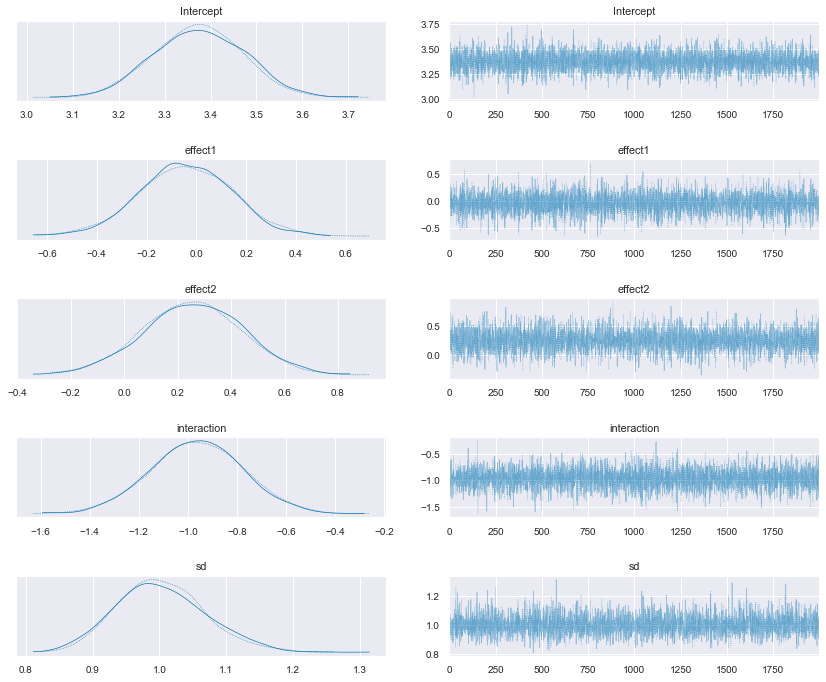

In [50]:
# figure
plt.figure(figsize = (14, 7))

# trace plot
pymc3.traceplot(tutorial_trace)

# fix plot
plt.tight_layout();

### Summary of results

In [51]:
pymc3.summary(tutorial_trace, hdi_prob = 0.95)

/Users/nicholasmichalak/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,3.373,0.095,3.181,3.546,0.001,0.001,5919.0,5919.0,5944.0,3086.0,1.0
effect1,-0.045,0.185,-0.383,0.352,0.002,0.003,6669.0,2065.0,6665.0,3125.0,1.0
effect2,0.254,0.183,-0.122,0.599,0.003,0.002,4690.0,4045.0,4677.0,3104.0,1.0
interaction,-0.966,0.185,-1.308,-0.576,0.002,0.002,6736.0,6352.0,6755.0,2970.0,1.0
sd,1.003,0.067,0.878,1.137,0.001,0.001,5665.0,5589.0,5698.0,2971.0,1.0


### Linear regression results for comparison

In [52]:
ols_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     10.86
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           2.44e-06
Time:                        11:19:13   Log-Likelihood:                -167.19
No. Observations:                 120   AIC:                             342.4
Df Residuals:                     116   BIC:                             353.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================
                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                         3.3871      0.090     37.430      0.000       3.208       3.566
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom0]    -0.0469      0.181     -0.259      0.796      -0.405       0.312
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom1]     0.2671      0.181      1.476      0.143      -0.091       0.626
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom2]    -0.9966      0.181     -5.506      0.000      -1.355      -0.638
==============================================================================
Omnibus:                        0.128   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.301
Skew:                           0.006   Prob(JB):                        0.860
Kurtosis:                       2.755   Cond. No.                         2.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Compare sd in trace plots to mean square residual in ANOVA source table

In [53]:
sm.stats.anova_lm(ols_fit2, type = 3)

,df,sum_sq,mean_sq,F,PR(>F)
"C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])",3.0,32.000675,10.666892,10.855187,0.000002
Residual,116.0,113.987855,0.982654,NaN,NaN
